Clean data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

In [3]:
# Donne plus de poids à certaines variables /// USELESS
# df['income'] = df['income'] * 2 
# df['credit_amount'] = df['credit_amount'] * 1.5  

In [4]:
df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [5]:
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

C:\Users\tosca\AppData\Local\Temp\ipykernel_23040\2903114193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Encoder

In [6]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

In [7]:
le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

ordinal_encoder = OrdinalEncoder(categories=[['Incomplete secondary education', 'Secondary education', 'Secondary special education','Incomplete higher education', 'Higher education', 'PhD degree']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

target_encoder = TargetEncoder(cols=['product_type', 'family_status'], smoothing=1.0)
df[['product_type', 'family_status']] = target_encoder.fit_transform(df[['product_type', 'family_status']], df['bad_client_target'])

df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,1,2.0,0.226908,0,2,21000,0.104080,0,0,0
1,1,19000,6,20,1,2.0,0.076433,1,2,17000,0.104080,3,1,0
2,1,29000,12,23,0,2.0,0.076433,0,2,31000,0.104080,2,0,0
3,1,10000,12,30,1,2.0,0.226908,1,2,31000,0.115385,3,1,0
4,1,14500,12,25,0,4.0,0.226908,0,2,26000,0.139640,0,1,0


Verification de colinéarité

In [8]:
import numpy as np
import seaborn as sns

correlation_matrix = df.corr()
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (correlation_matrix.iloc[i, j] == 1 or correlation_matrix.iloc[i, j] == -1) and i != j :
                print(f"Correlation of 1 or -1 found between '{correlation_matrix.index[i]}' and '{correlation_matrix.columns[j]}'")

<Axes: >

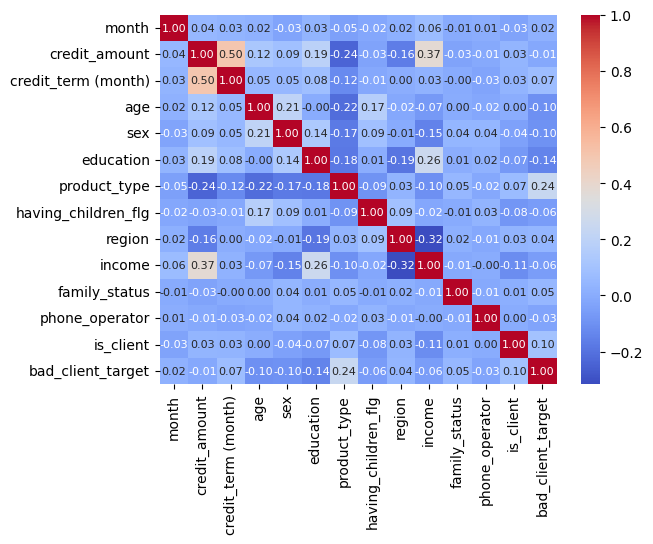

In [10]:
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

Data set

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop(columns=['bad_client_target']) # Region and phone op are useless data but better benchmark with 
y = df['bad_client_target'] 

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide dataset 80/20

Standardisation

In [12]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)  # Normalisation des données, (x-µ)/σ où : x = data, µ = moyenne de la colonne, σ = ecart-type de la colonne
X_test_scaled = scaler.transform(X_test)        # Donnée normalisé = même echelle = pas de donnée avec plus de poid

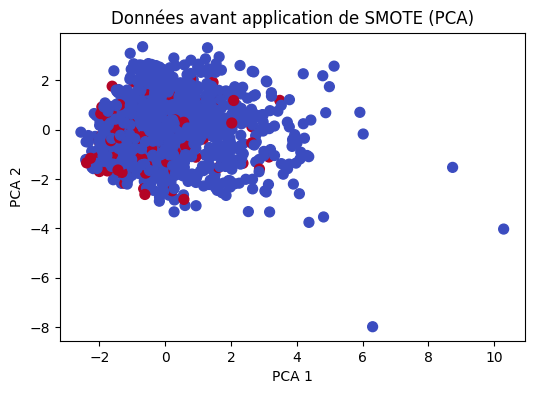

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualiser les données avant rééchantillonnage
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=50)
plt.title("Données avant application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Echantillonage des classes

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

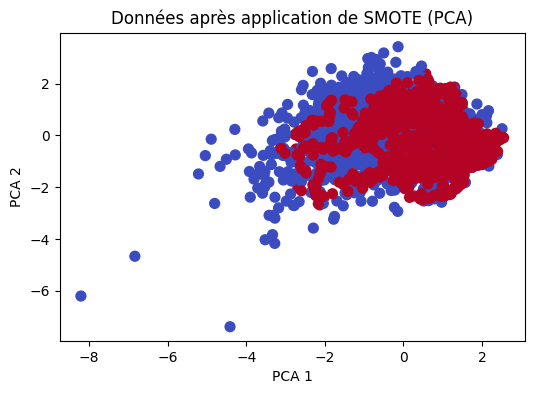

In [16]:
X_train_resampled_pca = pca.fit_transform(X_train_resampled)

# Visualiser les données rééchantillonnées après réduction de dimension
plt.figure(figsize=(6, 4))
plt.scatter(X_train_resampled_pca[:, 0], X_train_resampled_pca[:, 1], c=y_train_resampled, cmap='coolwarm', s=50)
plt.title("Données après application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

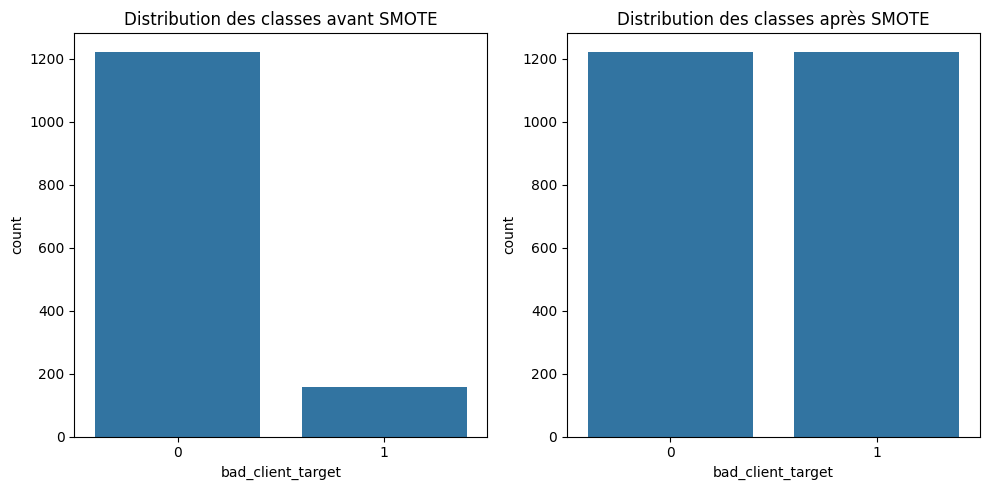

In [17]:
import seaborn as sns

# Distribution des classes avant et après SMOTE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Distribution des classes avant SMOTE")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title("Distribution des classes après SMOTE")

plt.tight_layout()
plt.show()

Modèle régrétion logistique avec équilibrage de classe

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
model = LogisticRegression(class_weight='balanced', C=10)               # instance de model scikitn, calcul de proba via regression logistique
model.fit(X_train_scaled, y_train)                                      # training

LogisticRegression(C=10, class_weight='balanced')

In [20]:
y_pred = model.predict(X_test_scaled)   # prédiction

In [21]:
# Benchmark
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

Accuracy: 0.6579710144927536

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       306
           1       0.18      0.59      0.28        39

    accuracy                           0.66       345
   macro avg       0.56      0.63      0.53       345
weighted avg       0.84      0.66      0.72       345



array([[204, 102],
       [ 16,  23]])

In [22]:
#Classification 

column_names = ['month', 'credit_amount', 'credit_term (month)', 'age', 'sex', 'education', 'product_type', 'having_children_flg', 'region', 'income', 'family_status', 'phone_operator', 'is_client']

new_data = pd.DataFrame([[
    11,                                 # month     Observation : A énormément de poid la décision du model
    50000,                              # credit_amount 
    12,                                 # credit_term 
    24,                                 # age 
    'female',                           # sex 
    'Incomplete secondary education',   # education
    'cellphone',                        # product_type
    3,                                  # having_children_flg
    1,                                  # region
    9000,                               # income
    'Unmarried',                        # family_status
    1,                                  # phone_operator
    1                                   # is_client
]], columns=column_names)

new_data['sex'] = le_sex.transform(new_data['sex'])
new_data['education'] = ordinal_encoder.transform(new_data[['education']])
new_data[['product_type', 'family_status']] = target_encoder.transform(new_data[['product_type', 'family_status']])


new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
prediction_proba = model.predict_proba(new_data_scaled)[:,1]
print(f"Prédiction pour la nouvelle donnée : {prediction} avec une proba de {prediction_proba}")

Prédiction pour la nouvelle donnée : [1] avec une proba de [0.68331516]


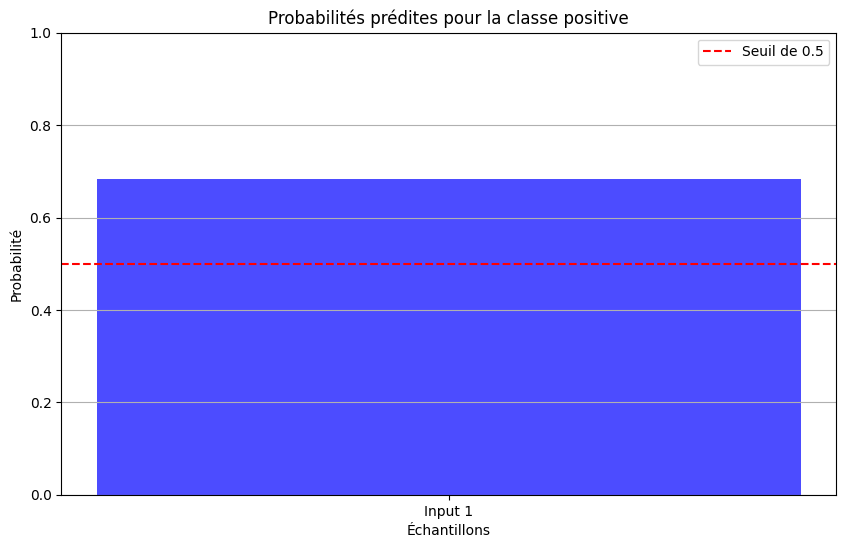

In [23]:
# Tracer les probabilités
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_proba)), prediction_proba, color='blue', alpha=0.7)
plt.xticks(range(len(prediction_proba)), [f'Input {i+1}' for i in range(len(prediction_proba))])
plt.title('Probabilités prédites pour la classe positive')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité')
plt.ylim(0, 1)
plt.grid(axis='y')

# Ajouter une ligne de seuil
threshold = 0.5  # Seuil par défaut pour la classification
plt.axhline(y=threshold, color='red', linestyle='--', label='Seuil de 0.5')
plt.legend()

plt.show()

In [24]:
#Classification 

column_names = ['month', 'credit_amount', 'credit_term (month)', 'age', 'sex', 'education', 'product_type', 'having_children_flg', 'region', 'income', 'family_status', 'phone_operator', 'is_client']

new_data = pd.DataFrame([[
    1,                                  # month (Janvier)
    17000,                              # credit_amount (Somme élevée)
    24,                                 # credit_term (24 mois)
    37,                                 # age (Adulte moyen)
    'female',                           # sex (1 pour féminin)
    'PhD degree',                       # education (PhD)
    'cellphone',                        # product_type (Produit fiable)
    1,                                  # having_children_flg (Pas d'enfants, indicatif de stabilité financière)
    1,                                  # region (Région sûre)
    70000,                              # income (Revenu élevé)
    'Married',                          # family_status (Marié, indicatif de stabilité)
    1,                                  # phone_operator (Opérateur fiable)
    1                                   # is_client (Client existant)
]], columns=column_names)

new_data['sex'] = le_sex.transform(new_data['sex'])
new_data['education'] = ordinal_encoder.transform(new_data[['education']])
new_data[['product_type', 'family_status']] = target_encoder.transform(new_data[['product_type', 'family_status']])


new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
prediction_proba = model.predict_proba(new_data_scaled)[:,1]
print(f"Prédiction pour la nouvelle donnée : {prediction} avec une proba de {prediction_proba}")

Prédiction pour la nouvelle donnée : [0] avec une proba de [0.31420671]


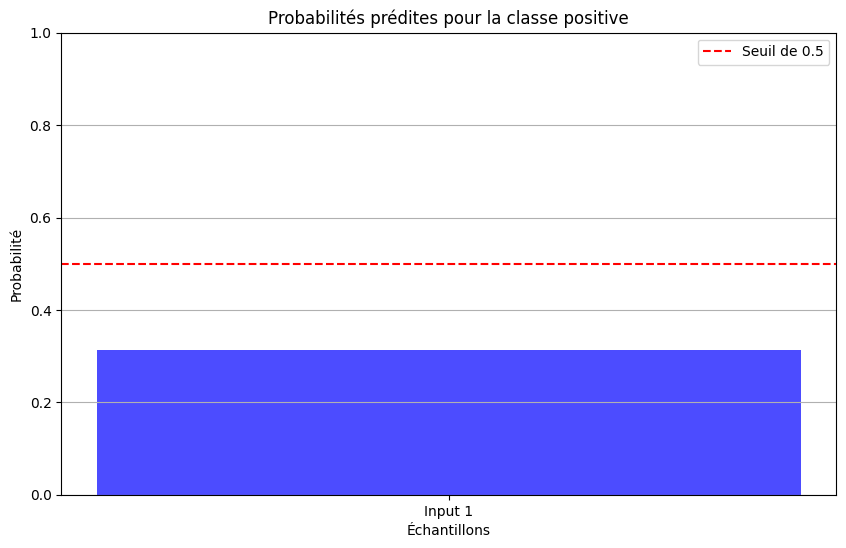

In [25]:
# Tracer les probabilités
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_proba)), prediction_proba, color='blue', alpha=0.7)
plt.xticks(range(len(prediction_proba)), [f'Input {i+1}' for i in range(len(prediction_proba))])
plt.title('Probabilités prédites pour la classe positive')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité')
plt.ylim(0, 1)
plt.grid(axis='y')

# Ajouter une ligne de seuil
threshold = 0.5  # Seuil par défaut pour la classification
plt.axhline(y=threshold, color='red', linestyle='--', label='Seuil de 0.5')
plt.legend()

plt.show()

Modèle de regression logistique avec rééchantillonnage

In [26]:
model_ressempled = LogisticRegression()                     # Aucun changement dans le benchmark avec ou sans équilibrage des classes.
model_ressempled.fit(X_train_resampled, y_train_resampled)                       

LogisticRegression()

In [27]:
y_pred_ressempled = model_ressempled.predict(X_test_scaled)   # prédiction

In [28]:
accuracy = accuracy_score(y_test, y_pred_ressempled)
print(f"Accuracy: {accuracy}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ressempled))
conf_matrix = confusion_matrix(y_test, y_pred_ressempled)
conf_matrix

Accuracy: 0.6579710144927536

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       306
           1       0.18      0.59      0.28        39

    accuracy                           0.66       345
   macro avg       0.56      0.63      0.53       345
weighted avg       0.84      0.66      0.72       345



array([[204, 102],
       [ 16,  23]])

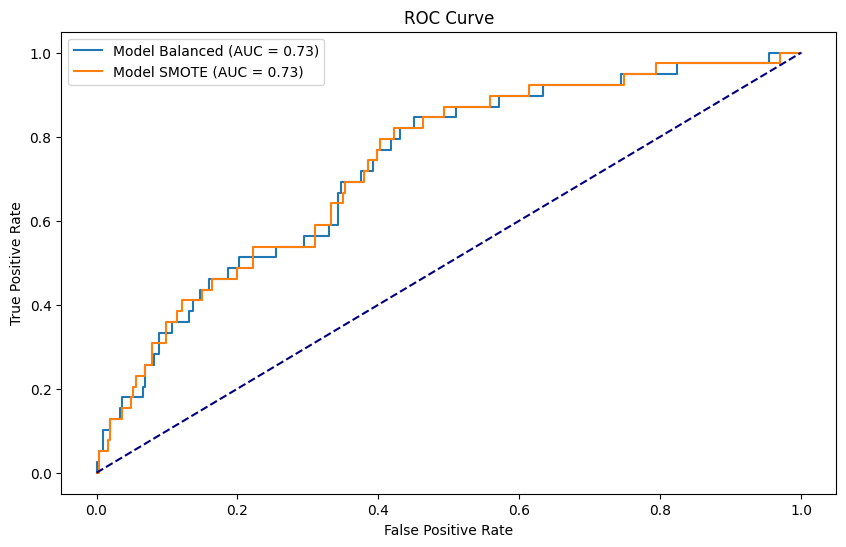

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédiction des probabilités
y_pred_proba_balanced = model.predict_proba(X_test_scaled)[:, 1]  # Pour le modèle balanced
y_pred_proba_smote = model_ressempled.predict_proba(X_test_scaled)[:, 1]  # Pour le modèle smote

# Courbe ROC
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_pred_proba_balanced)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)

# AUC
auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'Model Balanced (AUC = {auc_balanced:.2f})')
plt.plot(fpr_smote, tpr_smote, label=f'Model SMOTE (AUC = {auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


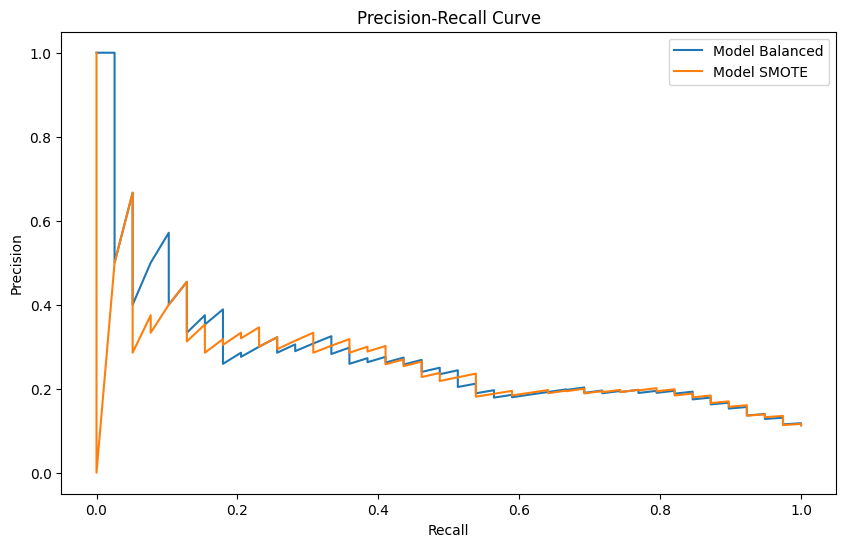

In [30]:
from sklearn.metrics import precision_recall_curve

# Courbe de précision-rappel
precision_balanced, recall_balanced, _ = precision_recall_curve(y_test, y_pred_proba_balanced)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_pred_proba_smote)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(recall_balanced, precision_balanced, label=f'Model Balanced')
plt.plot(recall_smote, precision_smote, label=f'Model SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

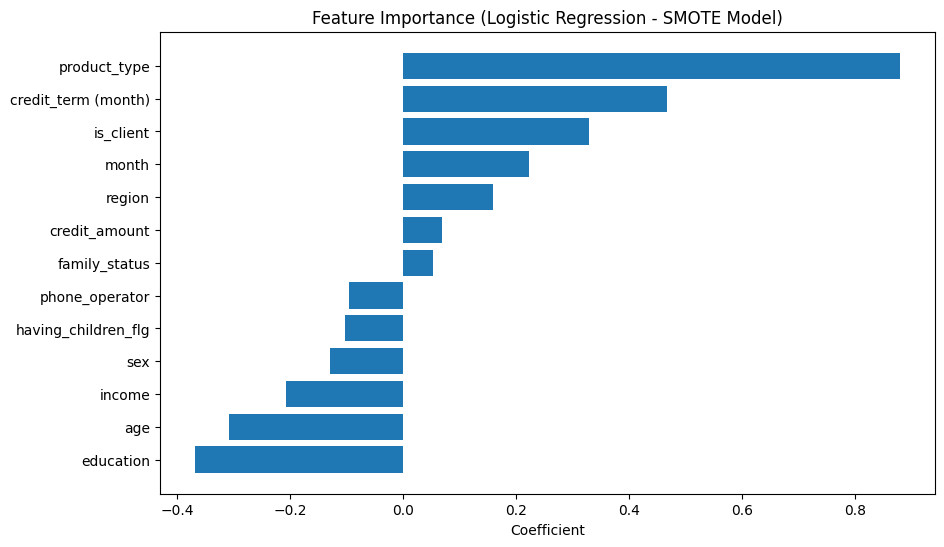

In [31]:
# Importance des caractéristiques pour le modèle SMOTE
coefficients = model_ressempled.coef_[0]
features = X_train.columns  # noms des colonnes

# Triez les caractéristiques par importance
indices = np.argsort(coefficients)

plt.figure(figsize=(10, 6))
plt.barh(features[indices], coefficients[indices])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression - SMOTE Model)")
plt.show()

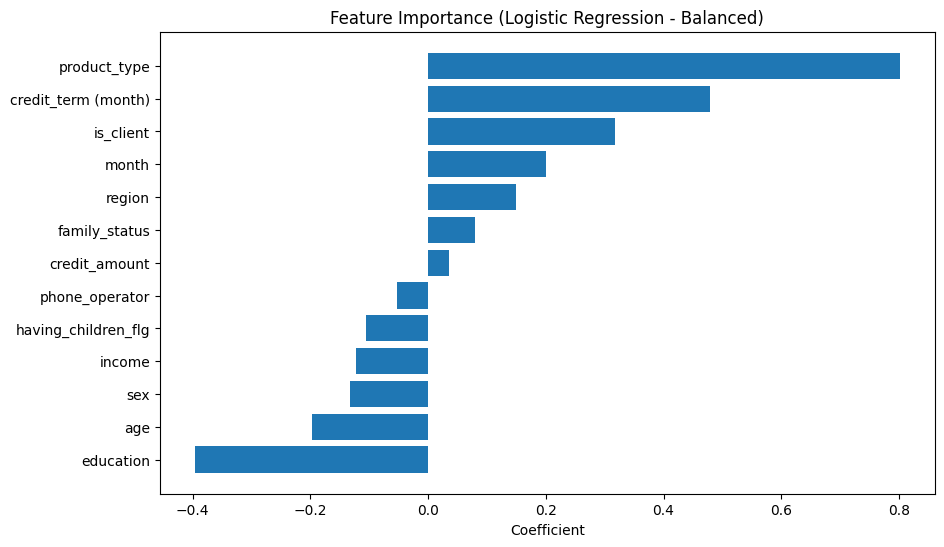

In [32]:
# Importance des caractéristiques pour le modèle SMOTE
coefficients = model.coef_[0]
features = X_train.columns  # noms des colonnes

# Triez les caractéristiques par importance
indices = np.argsort(coefficients)

plt.figure(figsize=(10, 6))
plt.barh(features[indices], coefficients[indices])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression - Balanced)")
plt.show()

Modèle KNN sans rééchantillonnage

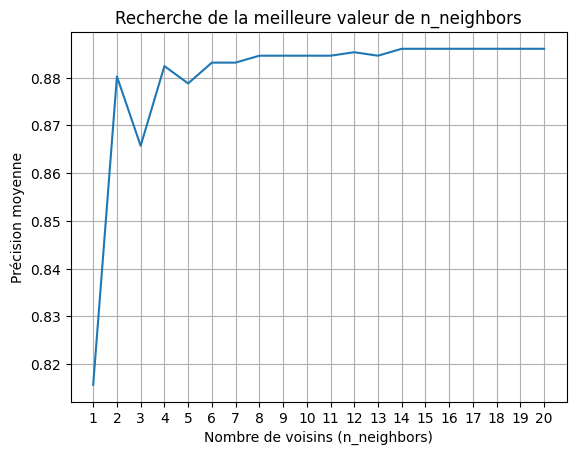

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Rechercher la meilleure valeur de n_neighbors
k_values = range(1, 21)  # n 1 -> 21
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)  # Validation croisée à 5 plis
    scores.append(np.mean(cv_scores))


plt.plot(k_values, scores)
plt.xlabel('Nombre de voisins (n_neighbors)')
plt.ylabel('Précision moyenne')
plt.title('Recherche de la meilleure valeur de n_neighbors')
plt.xticks(k_values)
plt.grid()
plt.show()

In [34]:
model_knn = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='kd_tree')
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)   # prédiction

In [35]:
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Précision : {accuracy:.2f}')

report = classification_report(y_test, y_pred_knn)
print('Rapport de classification :\n', report)

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print('Matrice de confusion :\n', conf_matrix)

Précision : 0.87
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       306
           1       0.25      0.08      0.12        39

    accuracy                           0.87       345
   macro avg       0.57      0.52      0.52       345
weighted avg       0.82      0.87      0.84       345

Matrice de confusion :
 [[297   9]
 [ 36   3]]


In [36]:
#Classification 

column_names = ['month', 'credit_amount', 'credit_term (month)', 'age', 'sex', 'education', 'product_type', 'having_children_flg', 'region', 'income', 'family_status', 'phone_operator', 'is_client']

new_data = pd.DataFrame([[
    11,                                 # month  
    50000,                              # credit_amount 
    12,                                 # credit_term 
    24,                                 # age 
    'female',                           # sex 
    'Incomplete secondary education',   # education
    'cellphone',                        # product_type
    3,                                  # having_children_flg
    1,                                  # region
    9000,                               # income
    'Unmarried',                        # family_status
    1,                                  # phone_operator
    1                                   # is_client
]], columns=column_names)

new_data['sex'] = le_sex.transform(new_data['sex'])
new_data['education'] = ordinal_encoder.transform(new_data[['education']])
new_data[['product_type', 'family_status']] = target_encoder.transform(new_data[['product_type', 'family_status']])


new_data_scaled = scaler.transform(new_data)
prediction_knn = model_knn.predict(new_data_scaled)
prediction_knn_proba = model_knn.predict_proba(new_data_scaled)[:,1]
print(f"Prédiction pour la nouvelle donnée : {prediction_knn} avec une proba de {prediction_knn_proba}")

Prédiction pour la nouvelle donnée : [0] avec une proba de [0.12706354]


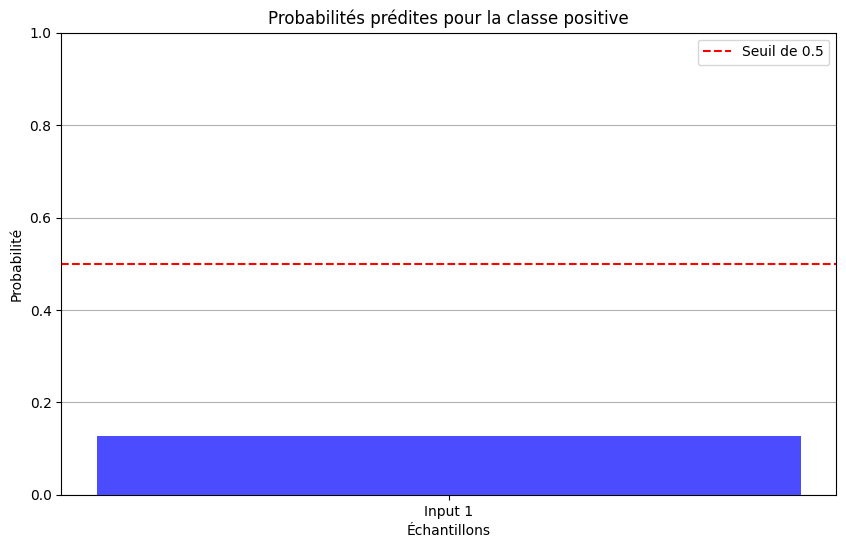

In [37]:
# Tracer les probabilités
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_knn_proba)), prediction_knn_proba, color='blue', alpha=0.7)
plt.xticks(range(len(prediction_knn_proba)), [f'Input {i+1}' for i in range(len(prediction_knn_proba))])
plt.title('Probabilités prédites pour la classe positive')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité')
plt.ylim(0, 1)
plt.grid(axis='y')

# Ajouter une ligne de seuil
threshold = 0.5  # Seuil par défaut pour la classification
plt.axhline(y=threshold, color='red', linestyle='--', label='Seuil de 0.5')
plt.legend()

plt.show()

KNN avec rééchantillonage

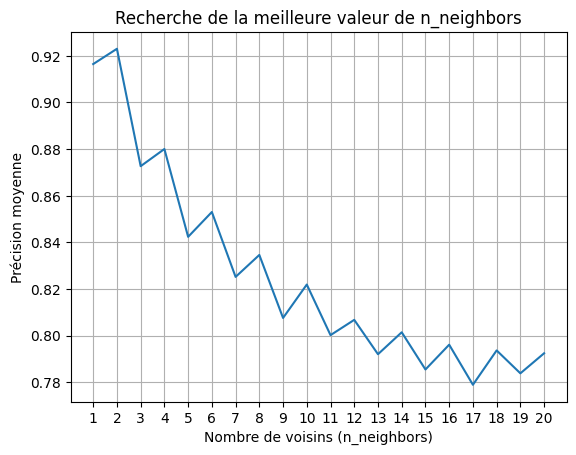

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Rechercher la meilleure valeur de n_neighbors
k_values = range(1, 21)  # n 1 -> 21
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5)  # Validation croisée à 5 plis
    scores.append(np.mean(cv_scores))


plt.plot(k_values, scores)
plt.xlabel('Nombre de voisins (n_neighbors)')
plt.ylabel('Précision moyenne')
plt.title('Recherche de la meilleure valeur de n_neighbors')
plt.xticks(k_values)
plt.grid()
plt.show()

In [39]:
model_knn_ressempled = KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='kd_tree')
model_knn_ressempled.fit(X_train_resampled, y_train_resampled)
y_pred_knn_ressempled = model_knn_ressempled.predict(X_test_scaled)   # prédiction

In [40]:
accuracy = accuracy_score(y_test, y_pred_knn_ressempled)
print(f'Précision : {accuracy:.2f}')

report = classification_report(y_test, y_pred_knn_ressempled)
print('Rapport de classification :\n', report)

conf_matrix = confusion_matrix(y_test, y_pred_knn_ressempled)
print('Matrice de confusion :\n', conf_matrix)

Précision : 0.77
Rapport de classification :
               precision    recall  f1-score   support

           0       0.90      0.83      0.86       306
           1       0.16      0.26      0.20        39

    accuracy                           0.77       345
   macro avg       0.53      0.54      0.53       345
weighted avg       0.81      0.77      0.79       345

Matrice de confusion :
 [[254  52]
 [ 29  10]]


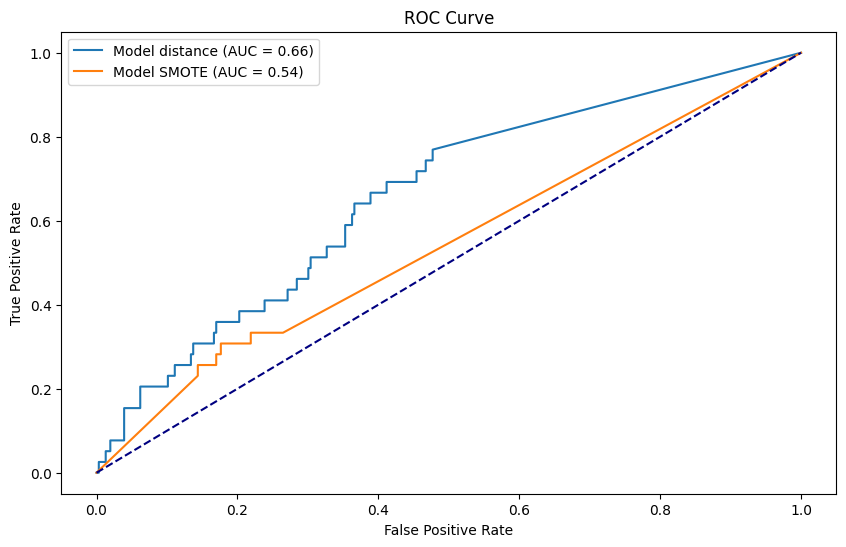

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédiction des probabilités
y_pred_proba_distance_knn = model_knn.predict_proba(X_test_scaled)[:, 1]  
y_pred_proba_smote_knn = model_knn_ressempled.predict_proba(X_test_scaled)[:, 1] 

# Courbe ROC
fpr_distance_knn, tpr_distance_knn, _ = roc_curve(y_test, y_pred_proba_distance_knn)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote_knn)

# AUC
auc_distance = roc_auc_score(y_test, y_pred_proba_distance_knn)
auc_smote = roc_auc_score(y_test, y_pred_proba_smote_knn)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(fpr_distance_knn, tpr_distance_knn, label=f'Model distance (AUC = {auc_distance:.2f})')
plt.plot(fpr_smote, tpr_smote, label=f'Model SMOTE (AUC = {auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


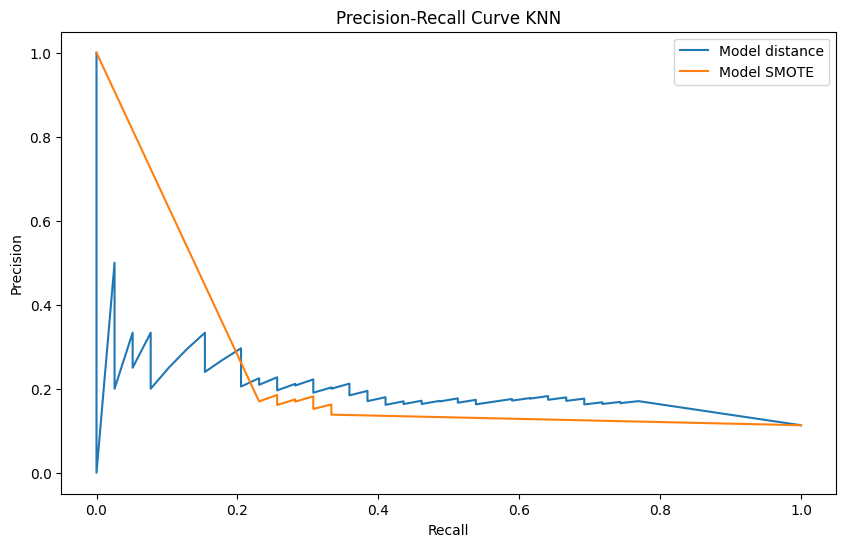

In [47]:
from sklearn.metrics import precision_recall_curve

# Courbe de précision-rappel
precision_distance_knn, recall_distance_knn, _ = precision_recall_curve(y_test, y_pred_proba_distance_knn)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_pred_proba_smote_knn)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(recall_distance_knn, precision_distance_knn, label=f'Model distance')
plt.plot(recall_smote, precision_smote, label=f'Model SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve KNN')
plt.legend()
plt.show()



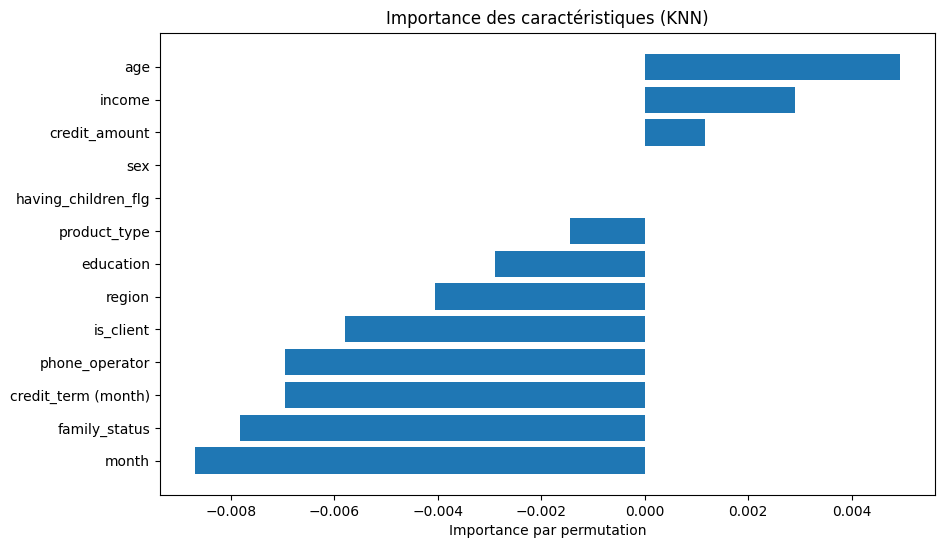

In [44]:
from sklearn.inspection import permutation_importance

# Appliquer l'importance des caractéristiques par permutation sur le modèle KNN
result = permutation_importance(model_knn, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Extraire les moyennes de l'importance
importance_means = result.importances_mean

# Triez les caractéristiques par importance
indices = np.argsort(importance_means)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[indices], importance_means[indices])
plt.xlabel("Importance par permutation")
plt.title("Importance des caractéristiques (KNN)")
plt.show()


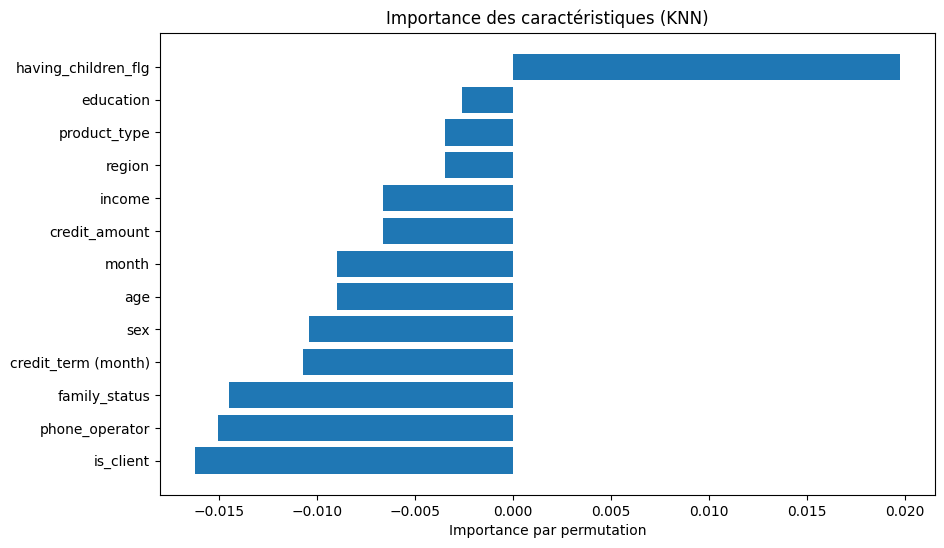

In [127]:
# Appliquer l'importance des caractéristiques par permutation sur le modèle KNN
result = permutation_importance(model_knn_ressempled, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Extraire les moyennes de l'importance
importance_means = result.importances_mean

# Triez les caractéristiques par importance
indices = np.argsort(importance_means)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[indices], importance_means[indices])
plt.xlabel("Importance par permutation")
plt.title("Importance des caractéristiques (KNN)")
plt.show()
